In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct

In [2]:
time_step = 212
phi = 0.40
lat_size = 100
Tu = 300.0         # unburned temperature [K]
p = ct.one_atm * 5    # pressure
df = pd.read_csv(f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref/extracted_flame_front_{time_step}.csv")

In [3]:
# for key in df.keys():
#     if key == "x" or key == "y":
#         continue
#     fig, ax = plt.subplots(figsize=(5, 2.5), dpi=200)
#     sc = ax.scatter(
#         df["x"],
#         df["y"],
#         c=df[key],        # color given by field
#         cmap="RdBu_r",
#         s=0.1,              # adjust point size as needed
#         edgecolors="none"
#     )
#
#     plt.title(f"Plot of {key}")
#     fig.colorbar(sc, ax=ax, label=key)
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     plt.tight_layout()
#     plt.show()

## Definition of progress variable

In [4]:
YH2_u = df[df["T"] == 1]["H2"].mean()
print(YH2_u)
df["progress_var"] = 1 - df["H2"]/YH2_u

0.011603087585122417


## PDF of reaction rates vs progress variable


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0002563  log(ss)= 1.78      

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.006568   log(ss)= 0.4772    

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.1122     log(ss)= 1.271     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.001873   log(ss)= 3.751     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 3.124e-05  log(ss)= 5.49      

Attempt Newton solution 

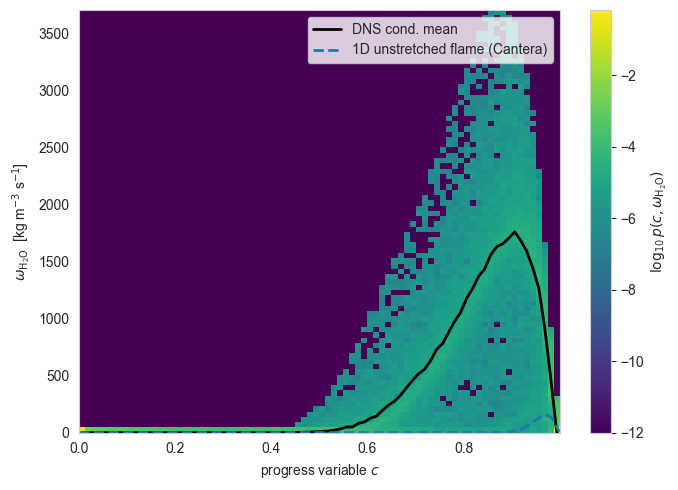

In [5]:

# ---------------------------------------------------------
# 0) DNS data from your dataframe
# ---------------------------------------------------------
x = df["progress_var"].to_numpy()
y = df["omega_H2O"].to_numpy()     # reaction rate of H2O, from DNS

# ---------------------------------------------------------
# 1) 2D histogram -> log-PDF of (progress_var, omega_H2O)
# ---------------------------------------------------------
nx = 80
ny = 80
H, xedges, yedges = np.histogram2d(x, y, bins=[nx, ny])
pdf = H / H.sum()
eps = 1e-12
log_pdf = np.log10(pdf + eps)
# Cell centers for plotting
Xc, Yc = np.meshgrid(
    0.5 * (xedges[:-1] + xedges[1:]),
    0.5 * (yedges[:-1] + yedges[1:])
)
# ---------------------------------------------------------
# 2) Conditional average E[omega_H2O | progress_var]
# ---------------------------------------------------------
sum_y, _   = np.histogram(x, bins=xedges, weights=y)
count_x, _ = np.histogram(x, bins=xedges)
with np.errstate(divide='ignore', invalid='ignore'):
    cond_mean = sum_y / count_x
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
# Optional: filter bins with too few samples
min_count = 20
mask = count_x >= min_count

# ---------------------------------------------------------
# 3) Cantera: 1D freely propagating unstretched H2–air flame
# ---------------------------------------------------------
mech = "../chemical_mech/BurkeH2.yaml"  # path to your Burke mechanism
gas = ct.Solution(mech)

gas.TP = Tu, p
gas.set_equivalence_ratio(phi, "H2", "O2:0.21, N2:0.79")

# 1D freely propagating flame
width = max(df["x"])
flame = ct.FreeFlame(gas, width=width)

# Inlet state (unburned)
flame.inlet.T = Tu
flame.inlet.X = gas.X

# Refinement criteria
flame.set_refine_criteria(curve= 0.2, slope = 0.1, ratio = 2)

# Solve flame
flame.solve(loglevel=1, auto=True)

# Extract profile for H2O
i_h2o = gas.species_index("H2O")

Y_H2O_profile = flame.Y[i_h2o, :]  # mass fraction H2O along flame
omega_kmol = flame.net_production_rates[i_h2o, :]  # [kmol/m^3/s]

# Convert to mass-based rate if your DNS omega is in kg/(m^3*s)
MW_H2O = gas.molecular_weights[i_h2o]   # [kg/kmol]
omega_mass = omega_kmol * MW_H2O        # [kg/m^3/s]

# --- PROGRESS VARIABLE (same definition as DNS) ---
i_h2 = gas.species_index("H2")
Y_H2_profile = flame.Y[i_h2, :]
Y_H2_u = Y_H2_profile[0]
c_flame = 1 - Y_H2_profile / Y_H2_u   # <-- identical to DNS

# ---------------------------------------------------------
# 4) Plot: DNS log-PDF + cond. mean + Cantera 1D curve
# ---------------------------------------------------------
plt.figure(figsize=(7, 5))

# Background log-PDF
pcm = plt.pcolormesh(Xc, Yc, log_pdf.T, shading="auto", cmap = 'viridis')
cbar = plt.colorbar(pcm)
cbar.set_label(r"$\log_{10} p(c, \omega_{\mathrm{H_2O}})$")

# Conditional average from DNS
plt.plot(x_centers[mask], cond_mean[mask],
         linewidth=2.0, color="k", label="DNS cond. mean")

# 1D flame curve (Cantera)
plt.plot(c_flame, omega_mass,
         linewidth=2.0, linestyle="--", label="1D unstretched flame (Cantera)")

plt.xlabel("progress variable $c$")
plt.ylabel(r"$\omega_{\mathrm{H_2O}}$  [kg m$^{-3}$ s$^{-1}$]")
plt.legend()
plt.tight_layout()
plt.show()


Explained variance: [0.71407476 0.17858361 0.09841964]


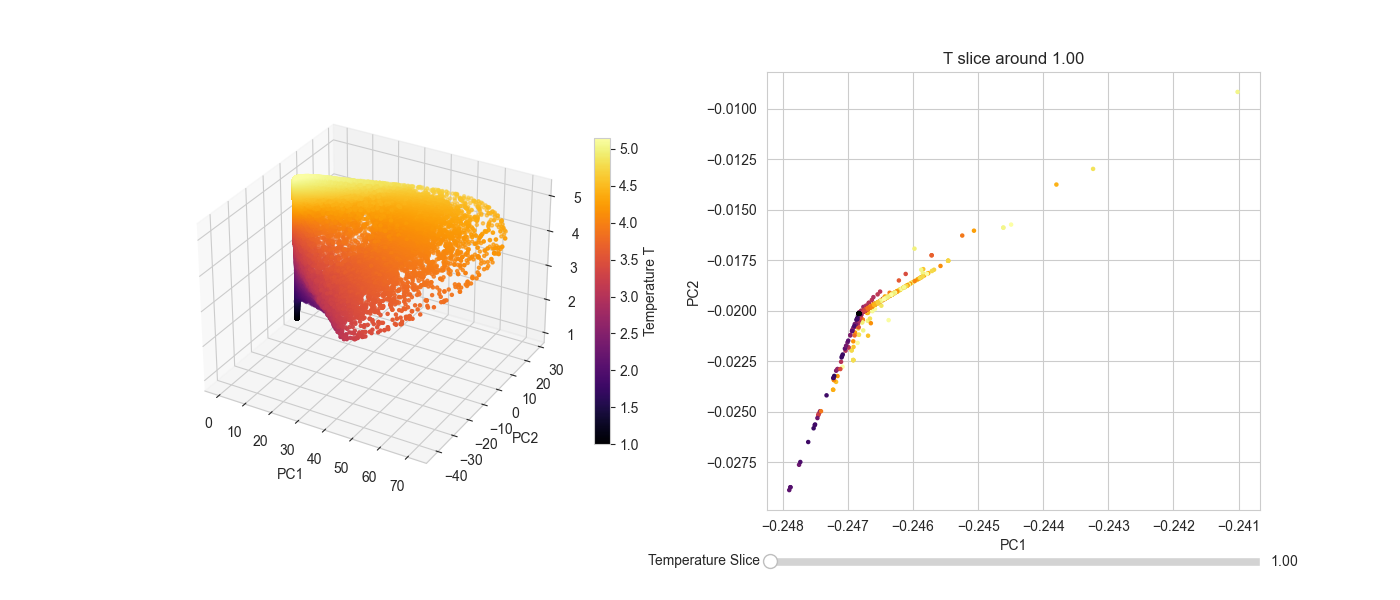

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
import matplotlib

# ---------------------------------------------------------
# 1) Extract PCA features (reaction rates + HRR)
# ---------------------------------------------------------
reaction_cols = [c for c in df.columns if c.startswith("omega_")]
reaction_cols.append("HRR")

X = df[reaction_cols].to_numpy()
T = df["T"].to_numpy()     # temperature for z-axis and slicing

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

PC1 = X_pca[:,0]
PC2 = X_pca[:,1]
PC3 = X_pca[:,2]

print("Explained variance:", pca.explained_variance_ratio_)

# ---------------------------------------------------------
# 2) Plot layout: left = 3D view, right = PC slices with slider
# ---------------------------------------------------------
fig = plt.figure(figsize=(14,6))

# --- Left: 3D scatter ---
ax3d = fig.add_subplot(121, projection="3d")
sc3d = ax3d.scatter(PC1, PC2, T, c=T, cmap="inferno", s=5)
ax3d.set_xlabel("PC1")
ax3d.set_ylabel("PC2")
ax3d.set_zlabel("T")
fig.colorbar(sc3d, ax=ax3d, shrink=0.7, label="Temperature T")

# --- Right: PC1–PC2 slice plot ---
ax2d = fig.add_subplot(122)
plt.subplots_adjust(bottom=0.15)  # space for slider

# initial slice around the minimum temperature
T_min, T_max = T.min(), T.max()
dT = 0.01 * (T_max - T_min)  # slice thickness (adjustable)
T_init = T_min

mask = np.abs(T - T_init) < dT
slice_scatter = ax2d.scatter(PC1[mask], PC2[mask], c=T[mask], cmap="inferno", s=5)
ax2d.set_xlabel("PC1")
ax2d.set_ylabel("PC2")
ax2d.set_title(f"T slice around {T_init:.2f}")

# ---------------------------------------------------------
# 3) Slider for temperature slices
# ---------------------------------------------------------
slider_ax = fig.add_axes([0.55, 0.05, 0.35, 0.03])
T_slider = Slider(
    ax=slider_ax,
    label="Temperature Slice",
    valmin=T_min,
    valmax=T_max,
    valinit=T_init,
    valstep=(T_max - T_min)/500
)

def update(val):
    T_val = T_slider.val
    mask = np.abs(T - T_val) < dT

    # update scatter plot
    slice_scatter.set_offsets(np.column_stack((PC1[mask], PC2[mask])))
    slice_scatter.set_array(T[mask])
    ax2d.set_title(f"T slice around {T_val:.2f}")

    fig.canvas.draw_idle()

T_slider.on_changed(update)

plt.show()
